## Inicjalizacja środowiska programistycznego

In [78]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Rowery Kraków

**Zagadnienie:** przewidzieć liczbę rowerzystów na wybranej ulicy Krakowa na podstawie zliczeń z `window_size-1` poprzednich dni.

**Proszę:**

* pobrać dane używając komórki poniżej
* naprawić ewentualne błędy
* wypisać na ekran podsumowanie danych

In [11]:
import pandas as pd

file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWNYLoE3k3JegSt47hV66v5j7_Vh8jIdLRUhcMLrIAW4VcIZK-3W9rGoDSfnToUnCIb9DPngGAlgL6/pub?gid=0&single=true&output=csv'
df = pd.read_csv(file_url)

df = pd.read_csv(file_url, sep=",",parse_dates=[0])
# df = df.rename(columns={' ' : "Data"})
# df = df.fillna(0)
# df.index = df['Date']
# df.drop(columns=['Date'], inplace=True)
# ...rozwiązanie...
pass

In [79]:
# df.index = df['Date']
# df.drop(columns=['Date'], inplace=True)

# df.describe()
df.columns

Index(['Armii Krajowej', 'Bora-Komorowskiego', 'Bulwary', 'Dworzec Główny',
       'Grzegórzecka', 'Kamieńskiego', 'Klimeckiego', 'Kopernika', 'Kotlarska',
       'Mogilska', 'Monte Cassino', 'Niepołomska', 'Nowohucka', 'Smoleńsk',
       'Tyniecka', 'Wadowicka', 'Wielicka',
       'Maksymalna temperatura dobowa [°C]',
       'Minimalna temperatura dobowa [°C]', 'Średnia temperatura dobowa [°C]',
       'Temperatura minimalna przy gruncie [°C]', 'Suma dobowa opadów [mm]'],
      dtype='object')

**Proszę:**

* zidentyfikowac dwie ulice o największym średnim natężeniu ruchu
* zachować nazwy tych ulic w zmiennych `train_street` i `val_street`

**Proszę:**

* dla obu ulic, na oddzielnych panelach, narysować zliczenia rowerzystów w funkcji daty

**Uwaga:**
* daty znajdują się teraz w indeksie:
```Python
df.index
```

In [31]:
print(df.mean(numeric_only=True))
train_street = "Mogilska"
val_street = "Kotlarska"

Armii Krajowej                              719.076923
Bora-Komorowskiego                          743.670630
Bulwary                                    1557.954779
Dworzec Główny                             1184.866062
Grzegórzecka                               1547.595849
Kamieńskiego                                796.133863
Klimeckiego                                1105.555468
Kopernika                                  1748.505155
Kotlarska                                  1631.787364
Mogilska                                   2060.731879
Monte Cassino                              1460.148041
Niepołomska                                 790.201465
Nowohucka                                   590.806106
Smoleńsk                                    722.768646
Tyniecka                                   1374.701742
Wadowicka                                   951.667415
Wielicka                                    933.282232
Maksymalna temperatura dobowa [°C]           15.891962
Minimalna 

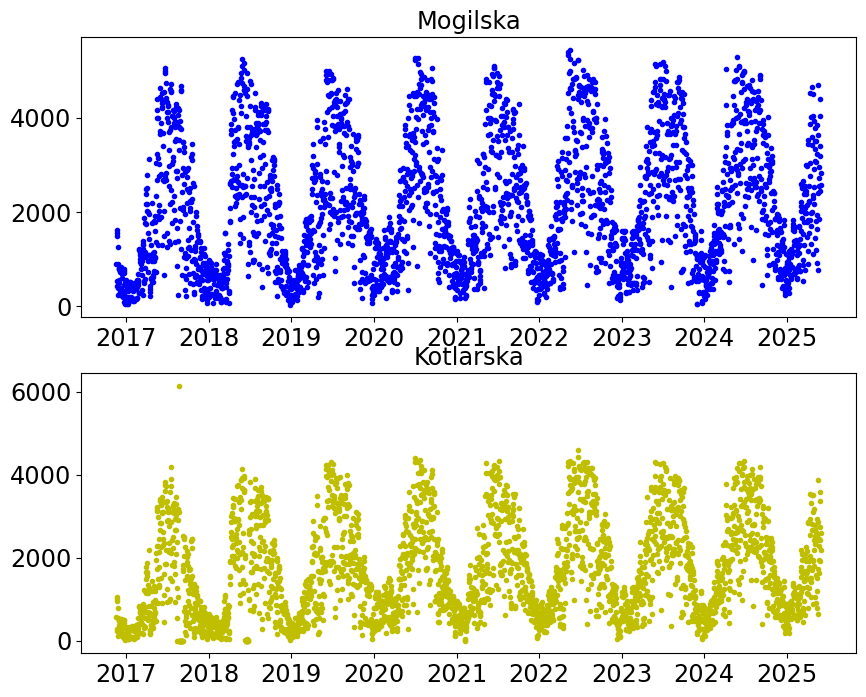

In [45]:
fig, axes = plt.subplots(2, 1, figsize = (10, 8))
axes[0].plot(df.index, df[train_street], 'b.')
axes[0].set_title(train_street)
axes[1].plot(df.index, df[val_street], 'y.')
axes[1].set_title(val_street)
plt.show()

**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, window_size, scale)` która przyjmuje obiekt `pandas.DataFrame` i zwraca obiekt `tf.Data.Dataset`.
Funkcja wykonuje następujące przekształcenia:

* dzieli dane na ciągi zliczeń z `window_size` dni
* normalizuje zliczenia o czynnik `1/scale`
* dzieli wiersze na `etykiety`: zliczenia z ostatniego dnia i `cechy`: zliczenia z wcześniejszych `window_size-1` dni
* dzieli zbiór na paczki o rozmiarze `16` i zachowuje go w pamięci podręcznej

**Wskazówki:**
* macierz danych z kolumny zbioru pandas można wyłuskać jako `df[...].values` lub podać po prostu `df[...]`
* macierze importujemy do `tf.data.Dataset` używając metody `from_tensor_slices(...)`

In [61]:
import datetime

def makeDataset(df, sequenceColumns, window_size, scale, batchSize=16):
    data = df[sequenceColumns].values
    data = data/scale

    # dataset = tf.data.Dataset.from_tensor_slices(data)
    # dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # dataset = dataset.flat_map(lambda window: window.batch(window_size))
    slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width = window_size, axis = 0)
    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(data))
    # def split_window(sequence):
    #     features = sequence[:-1]
    #     labels = sequence[-1]
    #     return features, labels

    # dataset = dataset.map(split_window)
    # dataset = dataset.batch(batchSize).cache()

    dataset = dataset.map(lambda x: tf.reshape(x, (window_size, len(sequenceColumns)))).map(lambda y: (y[:-1, :], y[-1, :])).batch(batchSize).cache()


    return dataset

x = makeDataset(df, [train_street], window_size=3, scale=1, batchSize=16)
for item in x.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0])

Features: [907. 438.] Labels: [549.]
Features: [291. 734.] Labels: [757.]
Features: [788. 759.] Labels: [702.]
Features: [369.  60.] Labels: [55.]


**Proszę:**

* sprawdzić czy podział danych jest poprawny, tzn. czy widać że zliczenia w kolejnych przykładach pochodzą z kolejnych dni


In [57]:
# Assuming 'df' is your original DataFrame and 'train_dataset' is created from it
# You might need to adjust the dataset variable name if you created a different one for testing

# Take a few examples from the dataset
test_window_size = 3 # This should match the window_size used to create 'x'
for i, item in enumerate(x.take(4)):
    features = item[0].numpy()[0,:,0]
    labels = item[1].numpy()[0]

    print(colored(f"Example {i+1}:","blue"))
    # Find the corresponding dates in the original DataFrame
    # The labels correspond to the last day in the window
    label_date_index = df.index.get_loc(df.index[i + test_window_size - 1])
    feature_dates = df.index[i : i + test_window_size - 1]
    label_date = df.index[i + test_window_size - 1]


    print(colored("Features (Dates and Counts):","green"))
    for j, date in enumerate(feature_dates):
        print(f"  {date.date()}: {features[j]}")

    print(colored("Label (Date and Count):","green"))
    print(f"  {label_date.date()}: {labels}")
    print("-" * 20)

Example 1:
Features (Dates and Counts):
  2016-11-18: 907.0
  2016-11-19: 438.0
Label (Date and Count):
  2016-11-20: [549.]
--------------------
Example 2:
Features (Dates and Counts):
  2016-11-19: 291.0
  2016-11-20: 734.0
Label (Date and Count):
  2016-11-21: [757.]
--------------------
Example 3:
Features (Dates and Counts):
  2016-11-20: 788.0
  2016-11-21: 759.0
Label (Date and Count):
  2016-11-22: [702.]
--------------------
Example 4:
Features (Dates and Counts):
  2016-11-21: 369.0
  2016-11-22: 60.0
Label (Date and Count):
  2016-11-23: [55.]
--------------------


Korzystając z funkcji `makeDataset(...)` proszę:

* utworzyć zbiory `train_dataset` i `val_dataset` ze zliczeniami z odpowiednich ulic.
* zbiór treningowy prosze ograniczyć do okresu `2017 - 2020`, a walidacyjny do okresu `2023 - 2024`
* szerokość okna ustawić na `32` dni
* skalę ustawić na `10_000`
* wypisać na ekran pierwsze 4 przykłady ze zbioru treningowego

**Wskazówka:**
* ograniczenie zakresu dat można uzyskać wybierając odpowiedni zakres wierszy w obiekcie `pandas.DataFrame` podawanym jako argument funkcji:
```Python
minTrainDate = datetime.date(2017, 1, 1)
maxTrainDate = datetime.date(2020, 12, 31)
df[minTrainDate:maxTrainDate]
```

In [68]:
window_size = 32
scale = 10_000

minTrainDate = datetime.date(2017, 1, 1)
maxTrainDate = datetime.date(2020, 12, 31)
minValDate = datetime.date(2023, 1, 1)
maxValDate = datetime.date(2024, 12, 31)

train_dataset = makeDataset(df[minTrainDate:maxTrainDate], [train_street], window_size, scale)
val_dataset = makeDataset(df[minValDate:maxValDate], [val_street], window_size, scale)

for item in train_dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0]*scale, end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]*scale)

Features: [172. 495. 414. 411. 369.  60.  55.  86. 326. 387. 366. 394. 479. 191.
 125. 514. 519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173.
 125. 331. 373.] Labels: [395.]
Features: [519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173. 125. 331.
 373. 395. 353. 374. 156. 112. 423. 406. 406. 383. 405. 169. 157. 368.
 449. 526. 569.] Labels: [411.]
Features: [ 353.  374.  156.  112.  423.  406.  406.  383.  405.  169.  157.  368.
  449.  526.  569.  411.  175.  189.  692.  449.  571.  512.  547.  278.
  290. 1199. 1224.  947. 1083. 1129. 1013.] Labels: [1046.]
Features: [ 175.  189.  692.  449.  571.  512.  547.  278.  290. 1199. 1224.  947.
 1083. 1129. 1013. 1046.  786. 1160. 1139.  897.  961.  668.  346. 1056.
 1324. 1220. 1293. 1390.  233.  548. 1112.] Labels: [1883.]


**Proszę:**

* zbudować model z warstwami LSTM:
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca tylko ostatni element sekwencji
    * warstwa gęsta, `1` neuron
* wypisać na ekran podsumowanie modelu    

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(8, return_sequences=True, input_shape=(None, 1)),
    LSTM(8),
    Dense(1, activation='sigmoid', name = 'traffic_prediction')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ traffic_prediction (Dense)      │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

**Proszę:**

* przeprowadzić trening modelu przez `150` epok/ Trening powinien zawierać standardowe elementy:
    * harmonogram zmiany współczynnika uczenia
    * wywołanie wczesnego zatrzymania
    * rysowane historii funkcji straty
* kod trenowania zawrzeć w funkcji `trainModel(model, train_dataset, val_dataset)`


Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.0000e-08
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.1220e-08
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.2589e-08
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.4125e-08
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.5849e-08
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0633 - mae: 0.3306 - val_loss: 0.0584 - val_mae: 0.3248 - learning_rate: 1.7783e-08
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0633 - mae: 0.3305 - val_loss: 0.0584 - val_mae: 0.3248 - lear

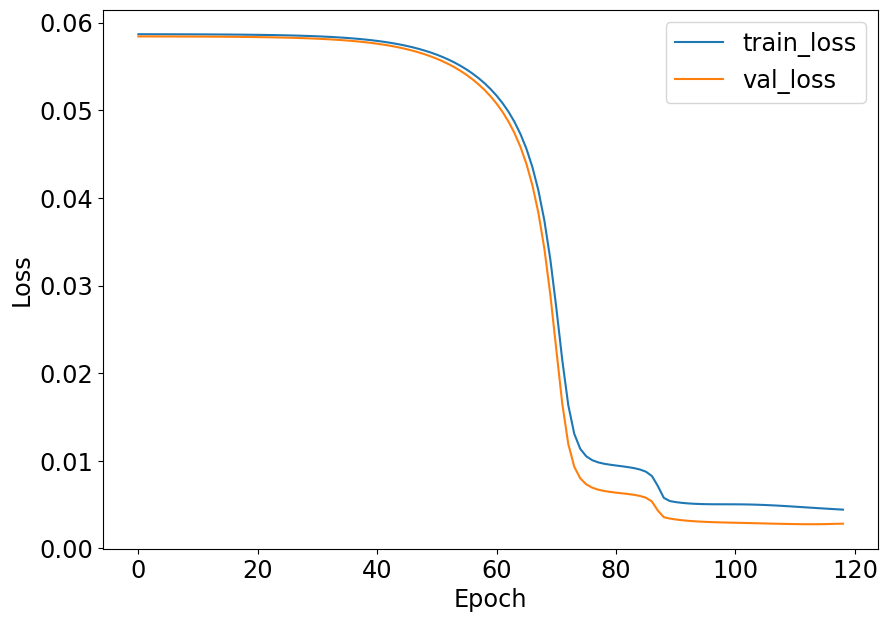

CPU times: user 7min 55s, sys: 10.8 s, total: 8min 6s
Wall time: 6min 28s


In [82]:
%%time
import tensorflow as tf

def trainModel(model, train_dataset, val_dataset):
    # Learning rate schedule
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])

    # Train the model
    history = model.fit(train_dataset,
                        epochs=200,
                        validation_data=val_dataset,
                        callbacks=[lr_schedule, early_stopping])

    # Plot loss history
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

model = trainModel(model, train_dataset, val_dataset)

**Proszę:**

Dokończyć funkcję  `plotPrediction(...)`, która wykonuje rysunki kontrolne dla podanych ulic.
Dla każdej ulicy są rysowane:


* liczby zliczeń rzeczywista i prognozowaną dla okresu `2024.07.01 - 2024.07.31`
* iloraz `rzeczywista/prognozowana` dla okresu `2022 - 2024`
* histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`
* histogram`(rzeczywista-prognozowana)/rzeczywista` dla modelu prognozowania naiwnego: `jutro będzie tak jak dziś`
* histogramy są rysowane na jednym panelu


**Wskazówki:**
* zakresy dat można na wykresie można kontrolować w następujący sposób:
```Python
axes[index,0].set_xlim([datetime.date(2024, 7, 1), datetime.date(2024, 7, 31)])
axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
```
* do uzyskania modelu naiwnego można użyć funkcji `np.roll()`


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


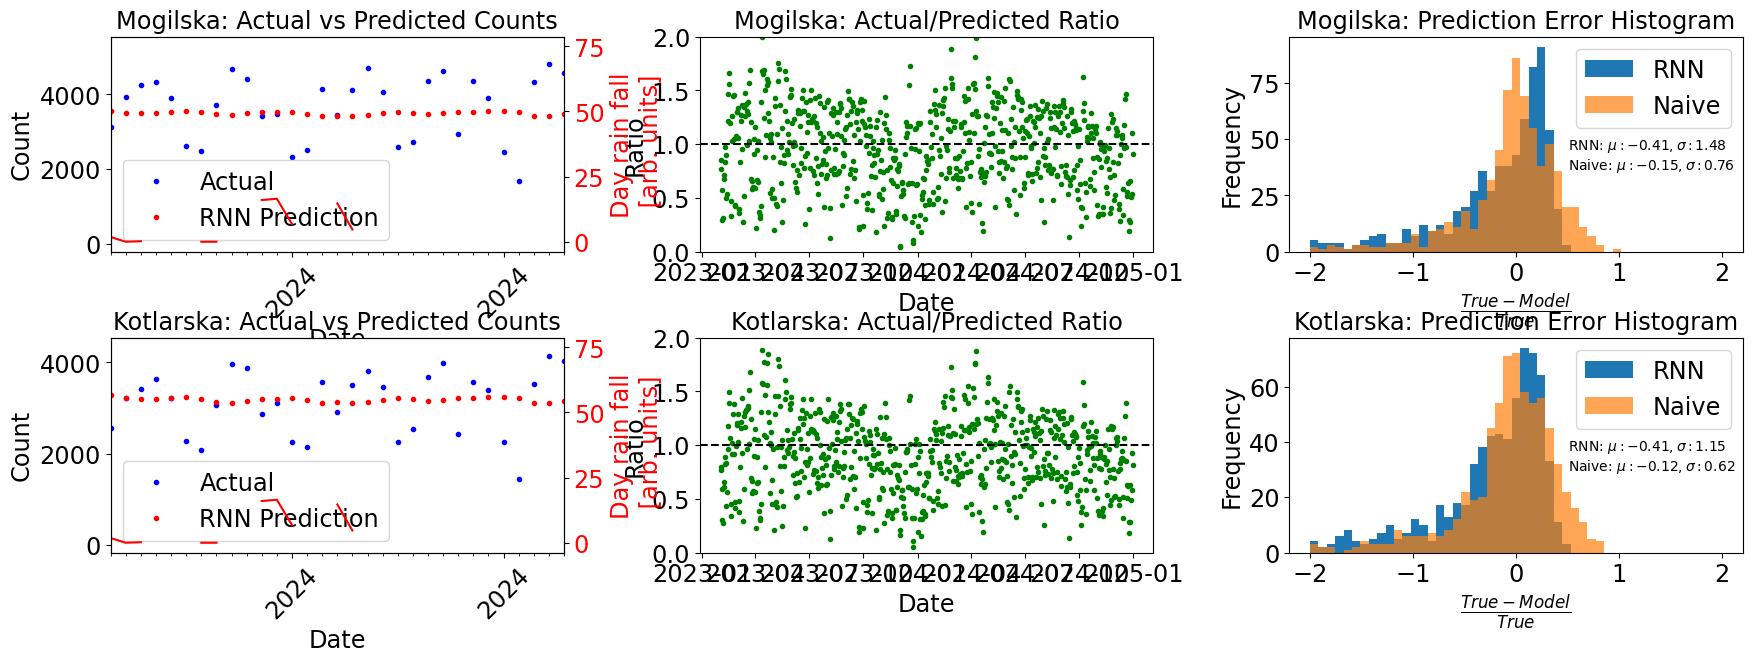

In [88]:
import matplotlib.dates as mdates
import datetime as dt # Use an alias for datetime

def plotPrediction(model, df, makeDataset, streets, window_size, scale):

    fig, axes = plt.subplots(2,3, figsize=(17,6))


    for index,street in enumerate(streets[:2]):
        df_tmp = df[minValDate:maxValDate]
        dataset = makeDataset(df=df_tmp, sequenceColumns=[street],
                              window_size=window_size,
                              scale=scale)
        date = df_tmp.index[window_size-1:]
        y = df_tmp[street][window_size-1:].values

        # Get predictions
        y_pred = model.predict(dataset) * scale
        y_pred = y_pred.flatten()

        # Naive prediction (tomorrow is like today)
        y_pred_naive = np.roll(y, -1)
        y_pred_naive[-1] = y_pred_naive[-2] # Handle the last element

        # Plot actual vs predicted counts for a specific date range
        axes[index,0].plot(date, y, 'b.', label='Actual')
        axes[index,0].plot(date, y_pred, 'r.', label='RNN Prediction')
        axes[index,0].set_title(f'{street}: Actual vs Predicted Counts')
        axes[index,0].set_xlabel('Date')
        axes[index,0].set_ylabel('Count')
        axes[index,0].legend()
        # Convert datetime.date objects to datetime.datetime objects for plotting limits
        axes[index,0].set_xlim([dt.datetime(2024, 7, 1), dt.datetime(2024, 7, 31)]) # Use the alias here
        axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
        axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
        axes[index,0].tick_params(axis='x', rotation=45)


        # Plot ratio of actual to predicted
        ratio = np.divide(y, y_pred, out=np.zeros_like(y, dtype=float), where=y_pred!=0)
        axes[index,1].plot(date, ratio, 'g.')
        axes[index,1].set_title(f'{street}: Actual/Predicted Ratio')
        axes[index,1].set_xlabel('Date')
        axes[index,1].set_ylabel('Ratio')
        axes[index,1].axhline(1, color='k', linestyle='--')
        axes[index,1].set_ylim([0, 2])


        # Plot histograms of prediction errors
        counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")
        axes[index,2].set_title(f'{street}: Prediction Error Histogram')
        axes[index,2].set_ylabel('Frequency')

        pull = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.5*counts.max(), r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        pull = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.4*counts.max(), r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        axes[index,2].legend()

        opadyColumn = "Suma dobowa opadów [mm]" # Corrected column name
        if opadyColumn in df.columns:
            ax2 = axes[index,0].twinx()
            # Align weather data with the prediction dates
            weather_data = df_tmp[opadyColumn][window_size-1:]
            ax2.plot(date, weather_data, 'r');
            ax2.tick_params(axis='y', labelcolor="r")
            ax2.yaxis.label.set_color('red')
            ax2.set_ylabel("Day rain fall\n [arb. units]")


    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.3, hspace=0.4)
    plt.show()


plotPrediction(model, df, makeDataset, [train_street, val_street], window_size, scale)

Zobaczmy czy dodanie danych o pogodzie poprawi wydajność modelu. Jako substytutu prognozy pogody użyjemy aktualnych danych pogodowych z dnia na który jest wykonywane przewidywanie ruchu rowerzystów.

Źródłem danych meteorologicznych jest Instytut Meteorologii i Gospodarki Wodnej – Państwowy Instytut Badawczy.
Dane o warunkach pogodowych pobierzemy z portalu [IMGW](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/).
Skorzystamy ze stacji Kraków-Balice.

In [76]:
import subprocess

# dowlnoad data
for year in range(2016, 2025):
    url = f"https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/{year}/{year}_566_s.zip"
    subprocess.run(["wget", url, "-P", "../data/Pogoda/"])

# unzip data
subprocess.run(["unzip","../data/Pogoda/*_566_s.zip", "-d","../data/Pogoda/"])

#remove zip archives
#file list expansion from * dos not work with subprocess
!rm -f ../data/Pogoda/*zip*

Dane załadujemy do obiektu Pandas dataframe.

**Proszę:**

Dokończyć funkcję `makeDataFrame(filePath)`, która wczytuje dane z pliku csv i tworzy obiekt `pandas.DataFrame`.
Funkcja wykonuje następujące operacje:

* wczytuje jedynie kolumny `2-22`
* używa kolumn `2-4` do utworzenia daty
* używa kodowania `Latin-1`
* usuwa kolumny zawierające `NaN`
* ustawia nazwy kolumn

In [89]:
import pandas as pd
"""naprawic ten syf, obrazki zle, wszystko zle"""
def makeDataFrame(filePath):
    columns = ["Data","zachmurzenie",
               "prędkość wiatru [m/s]", "temperatura [°C]",
               "ciśnienie pary wodnej [hPa]", "wilgotność względna [%]",
                "ciśnienie na poziomie stacji [hPa]", "ciśnienie na poziomie morza [hPa]",
                "suma opadu dzień  [mm]","suma opadu noc   [mm]"]
...rozwiązanie...
    return df

files = glob.glob("../data/Pogoda/s_d_t*.csv")
df_pogoda = pd.concat([makeDataFrame(file) for file in files])
df_pogoda.describe()

KeyError: 0

Połączymy obiekty dataframe z danymi o zliczeniach i pogodzie. Dla obu zbiorów ustawiamy datę jako indeks - dzięki temu zapewnimy synchronizację wierszy między oboma zbiorami.

In [ ]:
# set date as a index
df_pogoda.index = df_pogoda["Data"]

# drop index columns from weather df to avoid duplication
df_pogoda.drop(columns=["Data"], inplace=True)

# merge two dataframes. Only common dates are kept
df_merged = df.join(df_pogoda, how="inner")
df_merged.describe()

**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, featureColumns, window_size, scale)` która przygotowuje obiekt `tf.data.Dataset` z
danymi o zliczeniach - `sequenceColumns` i pogodzie - `featureColumns`.

Funkcja wykonuje następujące operacje:

* wczytuje dane z pandas DataFrame do `tf.data.Dataset`
* dzieli dane na okna o długości `window_size`
* dzieli wiersz danych na krotkę krotek: `((sekwencja zliczeń dla przeszłych dni, dane pogodowe dla danego dnia), zliczenia dla danego dnia)`

**Wskazówki:**

* jako listę kolumn wybieranych z obiektu `pandas.DataFrame` można podać
```Python
columns = sequenceColumns+featureColumns
```

* wszystkie dane wejściowe można podzielić na sekwencje o długości `window_size`, a potem z tej sekwencji wydzielić
  odpowiednie fragmenty. To o oznacza, że na początku sekwencja ma `inputDim = len(columns)` i trzeba z niej wydzielić dane
  o zliczeniach dla odpowiednich dni, etykietę i dane pogodowe

  Oczekiwany efekt dla paczki o rozmiarze 1:
  ```Python
  Features: (<tf.Tensor: shape=(1, 31, 1), dtype=float64, numpy=
  array([[[0.0172],
        [0.0495],
        [0.0414],
        [0.0411],
    ...
        [0.0331],
        [0.0373]]])>, <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[-7.40740741e-08,  0.00000000e+00,  1.00000000e-05]])>)
Labels: [0.0395]      
  ```

In [ ]:
def makeDataset(df, sequenceColumns, featureColumns, window_size, scale, batchSize=16):
...rozwiązanie...
    return dataset

df_merged["suma opadu dzień  [mm]"] = df_merged["suma opadu dzień  [mm]"]/40
df_merged["temperatura [°C]"] = df_merged["temperatura [°C]"]/30
df_merged["prędkość wiatru [m/s]"] = df_merged["prędkość wiatru [m/s]"]/10

featureColumns = ["temperatura [°C]","suma opadu dzień  [mm]","prędkość wiatru [m/s]"]
train_dataset = makeDataset(df_merged[minTrainDate:maxTrainDate],
                            [train_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale,
                            batchSize=16)

val_dataset = makeDataset(df_merged[minValDate:maxValDate],
                            [val_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale,
                            batchSize=16)

item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

**Proszę:**

* wywołać funkcję `makeDataset(...)` z takimi parametrami by można było łatwo sprawdzić czy dane pogodowe są dobrze zsynchronizowane,
  tzn. dane o pogodzie pochodzą z dnia dla którego model ma przewidzieć zliczenia

* porównać wartości dla pierwszego przykładu w obiekcie `pandas.DataFrame` z odpowiednim przykładem z  `tf.data.Dataset` i sprawdzić czy ten ostatni jest dobrze zsynchronizowany

In [ ]:
...rozwiązanie...
pass

## Model nie sekwencyjny

Skonstruujemy model, który składa się z dwu gałęzi:
* analiza sekwencji - gałąź rekurencyjna
* analiza przewidzianych zliczeń i danych o pogodzie - gałąź gęsta

![image.png](attachment:e50a6244-4179-4ee8-b18c-c2bae36e4350.png)

**Proszę**:

* utworzyć warstwy wejściowe z odpowiednimi kształtami

In [ ]:
# create input from counts
#BEIGN_SOLUTION
countsInputDim = 1
counts_input = tf.keras.Input(shape=(None, countsInputDim))

# create input from weather conditions
weatherInputDim = len(featureColumns)
weather_input = tf.keras.Input(shape=(weatherInputDim,))
...rozwiązanie...
pass

**Proszę:**

* utworzyć blok LSTM o architekturze jak dla poprzedniej sieci LSTM

In [ ]:
# create LSTM blocks
...rozwiązanie...
pass

**Proszę:**

* utworzyć warstę sklejającją, `concatenating`
* utworzyć blok FCC

In [ ]:
...rozwiązanie...
pass

**Proszę:**

* połączyć wszyski bloki w model
* narysować diagram modelu
* wypisać podsumowanie modelu na ekran
* urochomić model na danych

In [ ]:
...rozwiązanie...
pass

**Proszę:**

* przeprowadzić trening modelu z danymi meteorologicznymi
* wykonać rysunki kontrolne
* porównać jakość wyniku z poprzednim modelem

**Wskazówka:**
* nowa wersja funkcji `makeDataset(...)` bierze dodatkowy argument - `featureColumns`.
 Korzystając z `functools.partial(...)` można nadać temu argumentowi
  wartość i przekazać do funkcji rysującej wersję  `makeDataset(...)`, która nie będzie wymagała tego dodatkowego argumentu

In [ ]:
...rozwiązanie...
pass

# Zadanie domowe

**Proszę:**

* dodać do obiektu `pandas.DataFrame` kolumnę z numerem tygodnia
* skonstruować model, który jako sekwencje wejściowe będzie brał dane z ulic:
    ```Python
    ["Mogilska", "Kotlarska", "Bulwary", "Wadowicka", "Wielicka"]
    ```
   oraz numer dnia tygodnia
* jako dane o pogodzie będzie przyjmował kolumny `suma opadu dzień  [mm]` i `temperatura [°C]`
* przyjąć że pierwsza ulica z listy to ulica, dla której jest liczona prognoza
* zbiór treningowy ograniczyć do okresu `2017 - 2021`
* zbiór walidacyjny ograniczyć do okresu `2022 - 2024`
* sprawdzić czy dane w obiekcie `tf.data.Dataset` są dobrze przygotowane
* przeprowadzić trening
* narysować rysunki kontrolne dla ulicy `Mogilskiej` (takie jak na wykładzie)
    * górny wiersz dla zakresu `01.05.2024 - 31.07.2024`
    * dolny dla zakresu `01.08.2024 - 31.12.2024`
* przeprowadzić trening dla różnych szerokości okna czasowego i wskazać dającą najlepsze. Jako metryki użyć `średniego błedu kwadratowego` na zbiorze walidacyjnym.

In [ ]:
# add day of week to data
...rozwiązanie...
pass

In [ ]:
# prepare traion and validation datasets
...rozwiązanie...
item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

In [ ]:
# check if the data is aligned
...rozwiązanie...
pass

In [ ]:
# contruct model
...rozwiązanie...
#Run model on trainig dataset to check if it works
model.predict(train_dataset);

In [ ]:
# prepare plotting function
...rozwiązanie...
    pass

In [ ]:
# train model and make control plots
...rozwiązanie...
pass